In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"khaledeissa","key":"d7b46889813b6720140dd040c8c468a5"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets list

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
!kaggle datasets download -d hamzaboulahia/hardfakevsrealfaces

hardfakevsrealfaces.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip hardfakevsrealfaces.zip
import zipfile
import os
import shutil
# Extract the contents of the zip file
zip_path = 'hardfakevsrealfaces.zip'
extract_path = 'hardfakevsrealfaces'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Specify the paths to the extracted data
csv_file = os.path.join(extract_path, 'data.csv')
root_dir = extract_path

Archive:  hardfakevsrealfaces.zip
replace data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: data.csv                
  inflating: fake/fake_1.jpg         
  inflating: fake/fake_10.jpg        
  inflating: fake/fake_100.jpg       
  inflating: fake/fake_101.jpg       
  inflating: fake/fake_102.jpg       
  inflating: fake/fake_103.jpg       
  inflating: fake/fake_104.jpg       
  inflating: fake/fake_105.jpg       
  inflating: fake/fake_106.jpg       
  inflating: fake/fake_107.jpg       
  inflating: fake/fake_108.jpg       
  inflating: fake/fake_109.jpg       
  inflating: fake/fake_11.jpg        
  inflating: fake/fake_110.jpg       
  inflating: fake/fake_111.jpg       
  inflating: fake/fake_112.jpg       
  inflating: fake/fake_113.jpg       
  inflating: fake/fake_114.jpg       
  inflating: fake/fake_115.jpg       
  inflating: fake/fake_116.jpg       
  inflating: fake/fake_117.jpg       
  inflating: fake/fake_118.jpg       
  inflating: fake/fake_119.jpg    

In [ ]:
import shutil
shutil.rmtree("/content/fake")
shutil.rmtree("/content/real")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision.transforms import ToTensor, Resize
import torchvision.models as models
from PIL import Image
from sklearn.model_selection import train_test_split
import random
from sklearn.preprocessing import StandardScaler
import os
import glob
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score, roc_curve, f1_score
import torchvision.transforms as transforms

In [ ]:
# target labels
data=pd.read_csv("/content/hardfakevsrealfaces/data.csv")
data.head()

,images_id,label
0,real_1,real
1,real_10,real
2,real_100,real
3,real_101,real
4,real_102,real


In [ ]:
height, width = 128, 128
X = torch.empty((data.shape[0], 3, height, width))

transform_resize = Resize((height, width))
transform_tensor = ToTensor()

for i in range(data.shape[0]):
    img_path = "/content/hardfakevsrealfaces/{}/{}.jpg".format(data.loc[i, 'label'], data.loc[i, 'images_id'])
    image = Image.open(img_path).convert("RGB")
    resized_image = transform_resize(image)
    tensor_image = transform_tensor(resized_image)
    X[i] = tensor_image

X.shape

torch.Size([1289, 3, 128, 128])

In [ ]:
def change_labels(x):
    return label_dict[x]

labels = data.label.unique()
label_dict = {labels[i]: i for i in range(labels.size)}

y = data.label.apply(change_labels).values
y = torch.tensor(y)
y_onehot = torch.zeros(y.size(0), labels.size)
y_onehot.scatter_(1, y.view(-1, 1), 1)

y_onehot = y_onehot.type(torch.IntTensor)
y_onehot[:5]

tensor([[1, 0],
        [1, 0],
        [1, 0],
        [1, 0],
        [1, 0]], dtype=torch.int32)

In [ ]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=8)

# Convert numpy arrays to PyTorch tensors
X_train = torch.tensor(X_train).float()
X_test = torch.tensor(X_test).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()

print(X_train)
print(X_train.shape)

<ipython-input-32-2c9150095486>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train = torch.tensor(X_train).float()


tensor([[[[0.2824, 0.2471, 0.2510,  ..., 0.6196, 0.6000, 0.6118],
          [0.1961, 0.2000, 0.2863,  ..., 0.6235, 0.6000, 0.5569],
          [0.1451, 0.1608, 0.2941,  ..., 0.5686, 0.5176, 0.5333],
          ...,
          [0.1608, 0.1294, 0.1020,  ..., 0.0980, 0.0980, 0.0863],
          [0.1569, 0.1333, 0.1176,  ..., 0.0980, 0.0902, 0.0902],
          [0.1569, 0.1255, 0.1020,  ..., 0.1020, 0.0941, 0.0941]],

         [[0.2588, 0.2392, 0.2275,  ..., 0.3569, 0.3608, 0.4000],
          [0.1686, 0.1882, 0.2627,  ..., 0.3686, 0.3608, 0.3294],
          [0.1020, 0.1451, 0.2706,  ..., 0.3176, 0.2706, 0.2863],
          ...,
          [0.1137, 0.0902, 0.0824,  ..., 0.0471, 0.0549, 0.0431],
          [0.1020, 0.0941, 0.0941,  ..., 0.0431, 0.0471, 0.0471],
          [0.0980, 0.0824, 0.0745,  ..., 0.0471, 0.0510, 0.0471]],

         [[0.2000, 0.1569, 0.1294,  ..., 0.1961, 0.1882, 0.2196],
          [0.1059, 0.1059, 0.1647,  ..., 0.2000, 0.1843, 0.1490],
          [0.0471, 0.0627, 0.1725,  ..., 0

<ipython-input-32-2c9150095486>:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_test).float()
<ipython-input-32-2c9150095486>:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train).float()
<ipython-input-32-2c9150095486>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).float()


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=3)
        self.conv2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 14 * 14, 64)
        self.dropout = nn.Dropout(0.45)
        self.fc2 = nn.Linear(64, 2)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 32 * 14 * 14)
        x = nn.functional.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.softmax(self.fc2(x))
        return x

In [ ]:
model = Net()

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(X_train, torch.argmax(y_train, dim=1))
test_dataset = TensorDataset(X_test, torch.argmax(y_test, dim=1))
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
# # Training process
# epochs = 8
# for epoch in range(epochs):
#     running_loss = 0.0
#     for images, labels in train_dataloader:
#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()
#         running_loss += loss.item()
#     print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_dataloader)}")

# Training process
epochs = 8
for epoch in range(epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_dataloader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_dataloader)}, Accuracy: {accuracy}%")


Epoch 1/8, Loss: 0.5152506521253875, Accuracy: 81.37730358874879%
Epoch 2/8, Loss: 0.33707838257153827, Accuracy: 98.15712900096993%
Epoch 3/8, Loss: 0.32489526452440204, Accuracy: 99.1270611057226%
Epoch 4/8, Loss: 0.32882683837052545, Accuracy: 98.73908826382153%
Epoch 5/8, Loss: 0.32575549140120996, Accuracy: 98.8360814742968%
Epoch 6/8, Loss: 0.31922282955863257, Accuracy: 99.61202715809894%
Epoch 7/8, Loss: 0.3192790240952463, Accuracy: 99.61202715809894%
Epoch 8/8, Loss: 0.3161714284709006, Accuracy: 99.90300678952474%


In [ ]:
# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_dataloader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy}%")

Test Accuracy: 99.6124031007752%


In [ ]:
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        probabilities = F.softmax(outputs, dim=1)
        _, predicted = torch.max(probabilities, 1)

        predictions.extend(probabilities[:, 1].tolist())
        true_labels.extend(labels.tolist())

In [ ]:
auc_roc = roc_auc_score(true_labels, predictions)
print(f"AUC-ROC: {auc_roc:.4f}")

AUC-ROC: 1.0000


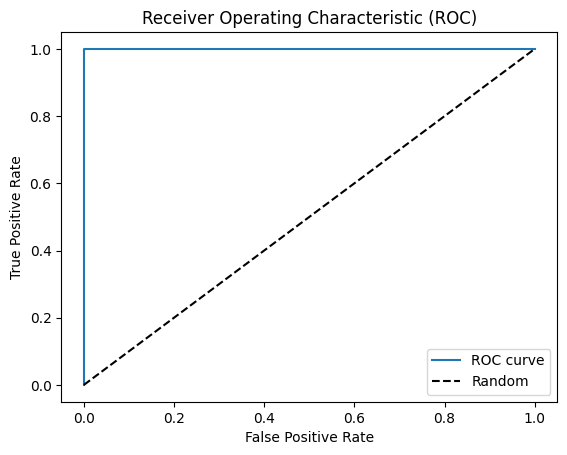

In [ ]:
fpr, tpr, thresholds = roc_curve(true_labels, predictions)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

In [ ]:
binary_predictions = [1 if p >= 0.5 else 0 for p in predictions]
f1 = f1_score(true_labels, binary_predictions)
print(f"F1 Score: {f1:.4f}")

F1 Score: 0.9959
